In [ ]:
import pandas as pd
import numpy as np
import os, sys
from collections import deque
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, IsolationForest, GradientBoostingRegressor
from scipy.stats import mannwhitneyu, shapiro, probplot
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import r2_score, mean_squared_error as mse, mean_absolute_error as mae
from sklearn.feature_selection import mutual_info_regression
from tqdm.notebook import tqdm
from IPython.display import clear_output
from sklearn.base import clone
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install catboost
from catboost import Pool, CatBoostRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
np.random.seed(1)
train_root = '/content/drive/My Drive/data/autoru/autoru_total.csv'
TARGET_NAME = 'Price'

In [ ]:
df = pd.read_csv(train_root)

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
def evaluate_preds(true_values, pred_values, save=False):
    print("R2:\t" + str(round(r2_score(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)) + "\n" +
          "MSE_scaled:\t" + str(round(mse(true_values, pred_values) / np.median(true_values), 3)))
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=pred_values, y=true_values, alpha=0.6)
    plt.plot([0, 2e+7], [0, 2e+7], linestyle='--', color='red')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    if save:
        if not os.path.exists('./saved'):
            os.makedirs('./saved')
        plt.savefig('./saved/' + 'report.png')
    plt.show()

def cross_validation(clf, X, y, scoring=None):
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring=scoring, n_jobs=-1)
    print(f'Меры правильности перекрекстной оценки: {scores}')
    print(f'Точность перекретсной оценки: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return scores

In [ ]:
df.head()

,Model,Year,Mileage,V_engine,EngineType,HorsePower,Tax,State,Owners,Passport,Customs,Selector,Color,CarBodyType,Accidents,Drive,Price
0,Subaru Forester IV,2013,83800.0,2.5,Бензин,171.0,8379.0,Не требует ремонта,2 владельца,Оригинал,Растаможен,вариатор,серебристый,внедорожник 5 дв.,ДТП ненайдены,полный,1499999.0
1,Opel Zafira B Рестайлинг,2014,97265.0,1.8,Бензин,140.0,4900.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,механическая,чёрный,компактвэн,NaN,передний,1000000.0
2,Kia Rio IV,2017,48000.0,1.6,Бензин,123.0,3075.0,Не требует ремонта,2 владельца,Оригинал,Растаможен,автоматическая,синий,седан,NaN,передний,945000.0
3,Skoda Octavia II (A5) Рестайлинг,2011,292000.0,1.4,Бензин,122.0,4148.0,Не требует ремонта,2 владельца,Оригинал,Растаможен,роботизированная,серебристый,лифтбек,NaN,передний,535000.0
4,Audi A6 IV (C7) Рестайлинг,2015,106205.0,1.8,Бензин,190.0,9500.0,Не требует ремонта,2 владельца,Оригинал,Растаможен,роботизированная,чёрный,седан,NaN,передний,1764000.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35700 entries, 0 to 36905
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Model        35700 non-null  object 
 1   Year         35700 non-null  int64  
 2   Mileage      35700 non-null  float64
 3   V_engine     35700 non-null  float64
 4   EngineType   35700 non-null  object 
 5   HorsePower   35700 non-null  float64
 6   Tax          35239 non-null  float64
 7   State        35696 non-null  object 
 8   Owners       35698 non-null  object 
 9   Passport     35700 non-null  object 
 10  Customs      35699 non-null  object 
 11  Selector     35700 non-null  object 
 12  Color        35700 non-null  object 
 13  CarBodyType  35700 non-null  object 
 14  Accidents    8091 non-null   object 
 15  Drive        35700 non-null  object 
 16  Price        35700 non-null  float64
dtypes: float64(5), int64(1), object(11)
memory usage: 4.9+ MB


In [ ]:
df.describe()

,Year,Mileage,V_engine,HorsePower,Tax,Price
count,35700.000000,35700.000000,35700.000000,35700.000000,35239.000000,3.570000e+04
mean,2011.029944,150702.729328,2.945423,171.928067,12394.124578,1.413787e+06
std,6.719819,95645.177437,14.640703,86.029600,20209.423408,1.741808e+06
min,1923.000000,1.000000,0.500000,11.000000,0.000000,2.500000e+04
25%,2008.000000,81380.750000,1.600000,115.000000,2925.000000,4.600000e+05
50%,2012.000000,140000.000000,2.000000,150.000000,5130.000000,8.750000e+05
75%,2016.000000,200664.000000,2.500000,200.000000,10000.000000,1.714000e+06
max,2021.000000,1000000.000000,560.000000,761.000000,292500.000000,3.999000e+07


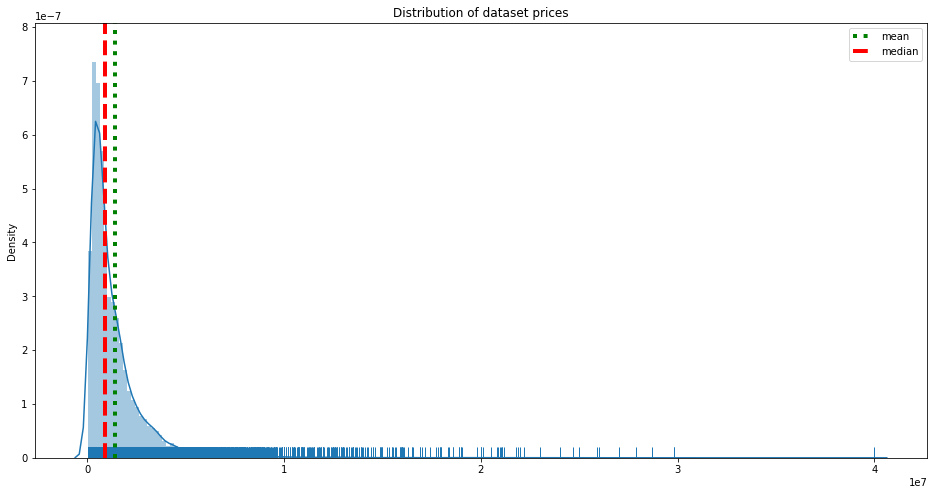

In [ ]:
df_pred = pd.DataFrame({'Price': df.Price})
target_mean = round(df_pred['Price'].mean(), 2)
target_median = df_pred['Price'].median()

plt.figure(figsize = (16, 8))

sns.distplot(df_pred, bins=200, rug=True)

plt.axvline(target_mean, label='mean', linestyle=':', color='green', linewidth=4)
plt.axvline(target_median, label='median', linestyle='--', color='red', linewidth=4)

plt.title('Distribution of dataset prices')
plt.legend()
plt.show()

In [ ]:
# distplot - distribution
# boxplot - outliers
# barplot - categorical counts
# scatter - outliers
# fillna - 
# outliers - isolation forest,

In [ ]:
df = df.sample(frac=1)

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1, shuffle=True, random_state=1)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32130 entries, 20346 to 29762
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Model        32130 non-null  object 
 1   Year         32130 non-null  int64  
 2   Mileage      32130 non-null  float64
 3   V_engine     32130 non-null  float64
 4   EngineType   32130 non-null  object 
 5   HorsePower   32130 non-null  float64
 6   Tax          31715 non-null  float64
 7   State        32126 non-null  object 
 8   Owners       32129 non-null  object 
 9   Passport     32130 non-null  object 
 10  Customs      32129 non-null  object 
 11  Selector     32130 non-null  object 
 12  Color        32130 non-null  object 
 13  CarBodyType  32130 non-null  object 
 14  Accidents    7266 non-null   object 
 15  Drive        32130 non-null  object 
 16  Price        32130 non-null  float64
dtypes: float64(5), int64(1), object(11)
memory usage: 4.4+ MB


In [ ]:
train_df.isnull().sum()

Model              0
Year               0
Mileage            0
V_engine           0
EngineType         0
HorsePower         0
Tax              415
State              4
Owners             1
Passport           0
Customs            1
Selector           0
Color              0
CarBodyType        0
Accidents      24864
Drive              0
Price              0
dtype: int64

In [ ]:
train_df.describe()

,Year,Mileage,V_engine,HorsePower,Tax,Price
count,32130.000000,32130.000000,32130.000000,32130.000000,31715.000000,3.213000e+04
mean,2011.035170,150851.376595,2.918195,171.733676,12322.103295,1.410368e+06
std,6.728235,95746.841719,14.227572,85.646479,19984.246983,1.733226e+06
min,1923.000000,1.000000,0.500000,11.000000,0.000000,2.500000e+04
25%,2008.000000,81602.250000,1.600000,115.000000,2925.000000,4.600000e+05
50%,2012.000000,140000.000000,2.000000,150.000000,5145.000000,8.750000e+05
75%,2016.000000,201000.000000,2.500000,200.000000,10000.000000,1.708750e+06
max,2021.000000,1000000.000000,560.000000,761.000000,292500.000000,3.999000e+07


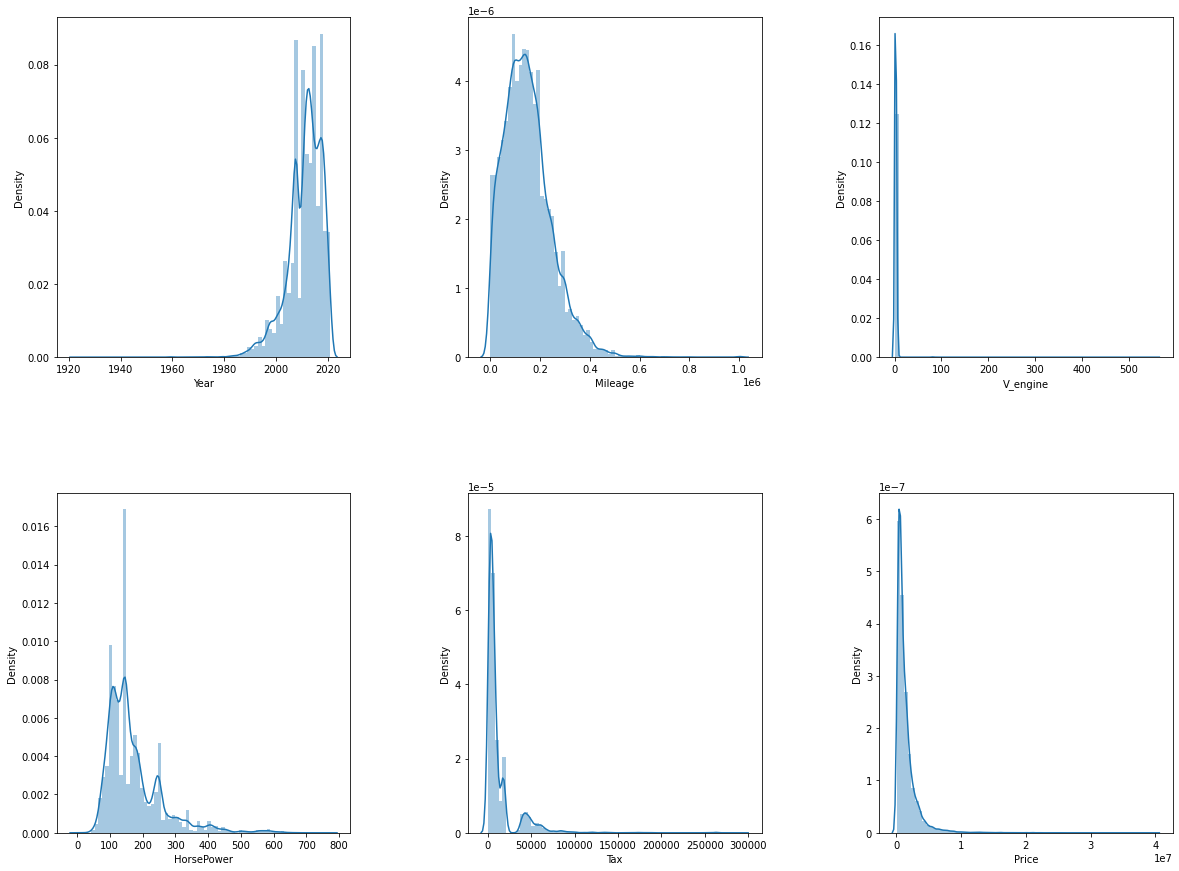

In [ ]:
# continuous variables
plt.figure(figsize=(20, 15))
numeric_cols = train_df.select_dtypes(['float', 'int']).columns
for idx, col in enumerate(numeric_cols):
    plt.subplot(2, 3, idx + 1)
    sns.distplot(train_df[col], bins=70)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

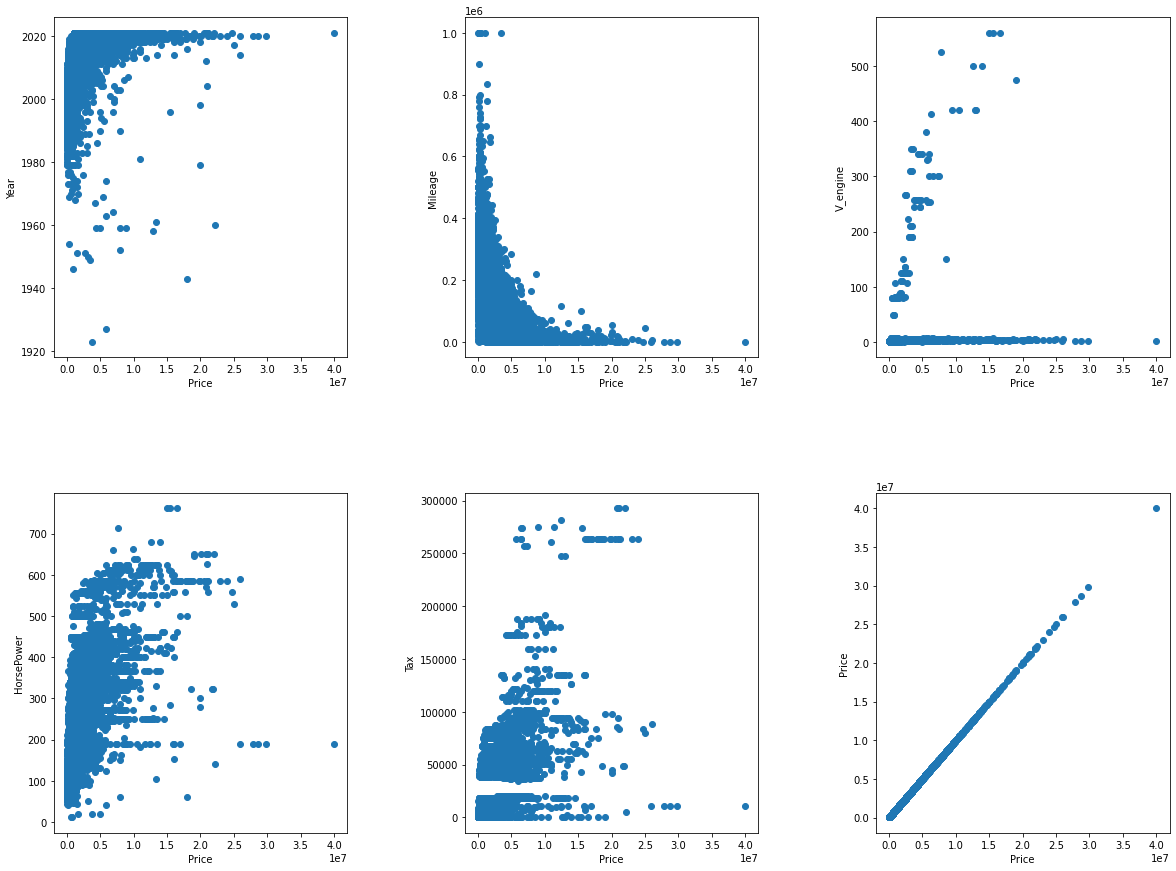

In [ ]:
plt.figure(figsize=(20, 15))
numeric_cols = train_df.select_dtypes(['float', 'int']).columns
for idx, col in enumerate(numeric_cols):
    plt.subplot(2, 3, idx + 1)
    plt.scatter(train_df[TARGET_NAME], train_df[col])
    plt.xlabel(TARGET_NAME)
    plt.ylabel(col)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

In [ ]:
# v_engine
train_df[train_df['V_engine'] > 20].head()

,Model,Year,Mileage,V_engine,EngineType,HorsePower,Tax,State,Owners,Passport,Customs,Selector,Color,CarBodyType,Accidents,Drive,Price
24388,Tesla Model 3 Long Range I,2020,43000.0,258.0,Электро,351.0,0.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,серый,седан,NaN,полный,4500000.0
15804,Nissan Leaf I (ZE0/AZE0),2014,111300.0,80.0,Электро,109.0,0.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,белый,хэтчбек 5 дв.,NaN,передний,630000.0
2658,Tesla Model Y Long Range I,2021,100.0,254.0,Электро,345.0,0.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,белый,внедорожник 5 дв.,NaN,полный,5780000.0
27178,Tesla Model X 100D I,2017,19000.0,525.0,Электро,714.0,0.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,чёрный,внедорожник 5 дв.,NaN,полный,7700000.0
5985,Fiat 500 II,2013,75300.0,82.0,Электро,111.0,0.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,серый,хэтчбек 3 дв.,NaN,передний,959999.0


In [ ]:
train_df[train_df['Price'] > 3.5e+7]
# drop

,Model,Year,Mileage,V_engine,EngineType,HorsePower,Tax,State,Owners,Passport,Customs,Selector,Color,CarBodyType,Accidents,Drive,Price
33424,Mercedes-Benz V-Класс XL 250 d экстра длинный II,2021,23.0,2.1,Дизель,190.0,10450.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,чёрный,минивэн,NaN,полный,39990000.0


In [ ]:
test_df[test_df['Price'] > 3.5e+7]

,Model,Year,Mileage,V_engine,EngineType,HorsePower,Tax,State,Owners,Passport,Customs,Selector,Color,CarBodyType,Accidents,Drive,Price


In [ ]:
train_df[train_df['Tax'] > 200000].head()
# ok

,Model,Year,Mileage,V_engine,EngineType,HorsePower,Tax,State,Owners,Passport,Customs,Selector,Color,CarBodyType,Accidents,Drive,Price
34839,Mercedes-Benz G-Класс AMG 63 AMG II (W463),2020,7540.0,4.0,Бензин,585.0,263250.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,чёрный,внедорожник 5 дв.,NaN,полный,18348000.0
18070,Mercedes-Benz G-Класс AMG 63 AMG II (W463),2019,32048.0,4.0,Бензин,585.0,263250.0,Не требует ремонта,2 владельца,Оригинал,Растаможен,автоматическая,чёрный,внедорожник 5 дв.,NaN,полный,16498000.0
30687,Mercedes-Benz G-Класс AMG 63 AMG II (W463),2020,6800.0,4.0,Бензин,585.0,263250.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,серый,внедорожник 5 дв.,NaN,полный,24000000.0
32679,Mercedes-Benz G-Класс AMG 63 AMG II (W463),2020,8000.0,4.0,Бензин,585.0,263250.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,чёрный,внедорожник 5 дв.,NaN,полный,23000000.0
13330,Mercedes-Benz G-Класс AMG 63 AMG II (W463),2020,2222.0,4.0,Бензин,585.0,263250.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,чёрный,внедорожник 5 дв.,NaN,полный,19800000.0


In [ ]:
train_df[train_df['Year'] < 1950]
# add year categories

,Model,Year,Mileage,V_engine,EngineType,HorsePower,Tax,State,Owners,Passport,Customs,Selector,Color,CarBodyType,Accidents,Drive,Price
17672,Ford Custom,1949,1000000.0,3.9,Бензин,100.0,1200.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,механическая,синий,купе,NaN,задний,3500000.0
23411,Ford GPA,1943,30.0,2.2,Бензин,60.0,600.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,механическая,зелёный,внедорожник открытый,NaN,полный,18000000.0
17115,BMW 321 I,1946,4500.0,2.0,Бензин,46.0,552.0,Не требует ремонта,2 владельца,Оригинал,Растаможен,механическая,бежевый,седан 2 дв.,NaN,задний,1000000.0
17704,Ford Model T,1923,1000.0,2.9,Бензин,20.0,240.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,механическая,зелёный,кабриолет,NaN,задний,3800000.0
32473,Ford Model A,1927,50000.0,3.3,Бензин,40.0,480.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,механическая,синий,хэтчбек 3 дв.,NaN,задний,5850000.0


In [ ]:
train_df[train_df['Mileage'] > 0.8e+6]
# IQR

,Model,Year,Mileage,V_engine,EngineType,HorsePower,Tax,State,Owners,Passport,Customs,Selector,Color,CarBodyType,Accidents,Drive,Price
14125,Toyota Corolla Levin VI (AE100/AE101),1993,1000000.0,1.6,Бензин,115.0,2875.0,Не требует ремонта,3 или более,Дубликат,Растаможен,механическая,чёрный,купе,NaN,передний,120000.0
4329,Toyota Land Cruiser 105 100 Series,2000,834000.0,4.2,Дизель,131.0,3930.0,Не требует ремонта,2 владельца,Оригинал,Растаможен,механическая,серебристый,внедорожник 5 дв.,NaN,полный,1380000.0
17672,Ford Custom,1949,1000000.0,3.9,Бензин,100.0,1200.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,механическая,синий,купе,NaN,задний,3500000.0
17793,Mercedes-Benz W124 230,1987,1000000.0,2.3,Бензин,136.0,4760.0,Не требует ремонта,3 или более,Оригинал,Растаможен,механическая,бежевый,седан,NaN,задний,420000.0
15128,Opel Kapitan II,1954,1000000.0,2.5,Бензин,68.0,816.0,Не требует ремонта,3 или более,Оригинал,Растаможен,механическая,чёрный,седан,NaN,задний,340000.0
18645,Mazda 626 III (GD),1991,900000.0,2.0,Бензин,107.0,3007.0,Не требует ремонта,3 или более,Оригинал,Растаможен,механическая,красный,седан,ДТП ненайдены,передний,100000.0
31279,Mitsubishi Pajero iO,1999,999999.0,1.8,Бензин,130.0,4420.0,Не требует ремонта,3 или более,Оригинал,Растаможен,автоматическая,синий,внедорожник 5 дв.,NaN,полный,210000.0
9214,Renault Megane I,1998,1000000.0,1.6,Бензин,75.0,750.0,Не требует ремонта,2 владельца,Оригинал,Растаможен,механическая,белый,седан,NaN,передний,30000.0
6627,BMW 3 серии 316i III (E36),1995,1000000.0,1.6,Бензин,102.0,2550.0,Не требует ремонта,3 или более,Оригинал,Растаможен,механическая,чёрный,купе,NaN,задний,1000000.0
20111,"Toyota Corona VII (T140, T150, T160)",1982,1000000.0,1.8,Бензин,95.0,1140.0,Не требует ремонта,3 или более,Дубликат,Растаможен,автоматическая,серый,седан,ДТП ненайдены,задний,97000.0


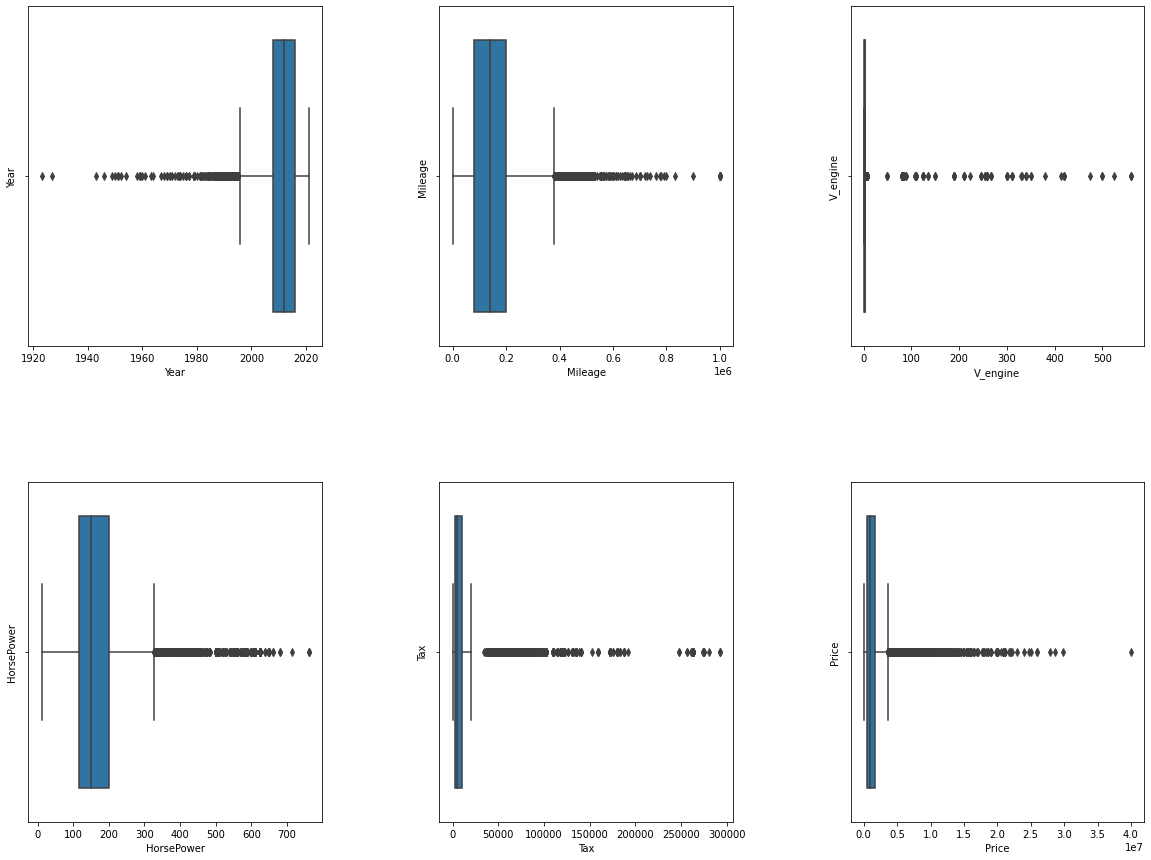

In [ ]:
plt.figure(figsize=(20, 15))
numeric_cols = train_df.select_dtypes(['float', 'int']).columns
for idx, col in enumerate(numeric_cols):
    plt.subplot(2, 3, idx + 1)
    sns.boxplot(train_df[col])
    plt.ylabel(col)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

In [ ]:
train_df.shape

(32130, 17)

In [ ]:
non_numeric_cols = train_df.select_dtypes(['object']).columns
for idx, col in enumerate(non_numeric_cols):
    print(train_df[col].value_counts())
    print('='*40)

Ford Focus II Рестайлинг                355
Ford Focus III                          352
Ford Focus II                           292
Chevrolet Lacetti                       242
Volkswagen Polo V Рестайлинг            228
                                       ... 
Mercedes-Benz AMG GT 63 I Рестайлинг      1
Citroen C3 Aircross I                     1
Subaru Forester STi II Рестайлинг         1
Suzuki Wagon R V                          1
Ford Bronco-II                            1
Name: Model, Length: 3052, dtype: int64
 Бензин                                27010
 Дизель                                 4447
 Бензин, газобаллонное оборудование      359
 Гибрид                                  201
 Электро                                 107
 Газ, газобаллонное оборудование           3
 Дизель, газобаллонное оборудование        2
 Газ                                       1
Name: EngineType, dtype: int64
Не требует ремонта    32126
Name: State, dtype: int64
3 или более    13485
1 владелец

In [ ]:
train_df['Model'].apply(lambda x: ' '.join(x.split()[:2])).unique().shape
# target encoding

(753,)

In [ ]:
iso = IsolationForest(n_estimators=100, contamination=0.0001, n_jobs=-1, random_state=1)
outlier_df = pd.DataFrame(columns=train_df.columns)
for col in train_df.select_dtypes(['float', 'int']).columns:
    df_to_train = train_df.fillna(method='bfill')
    outlier = iso.fit_predict(df_to_train[col].values.reshape(-1, 1))
    out = df_to_train[outlier == -1]
    outlier_df = outlier_df.append(out)
outlier_df
# possible outliers
# year = ok -> set to categories
# vengine = ok because of electro -> electro /= 100
# price = ok beacuse of special model -> stay

,Model,Year,Mileage,V_engine,EngineType,HorsePower,Tax,State,Owners,Passport,Customs,Selector,Color,CarBodyType,Accidents,Drive,Price
23411,Ford GPA,1943,30.0,2.2,Бензин,60.0,600.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,механическая,зелёный,внедорожник открытый,ДТП ненайдены,полный,18000000.0
17115,BMW 321 I,1946,4500.0,2.0,Бензин,46.0,552.0,Не требует ремонта,2 владельца,Оригинал,Растаможен,механическая,бежевый,седан 2 дв.,ДТП ненайдены,задний,1000000.0
17704,Ford Model T,1923,1000.0,2.9,Бензин,20.0,240.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,механическая,зелёный,кабриолет,ДТП ненайдены,задний,3800000.0
32473,Ford Model A,1927,50000.0,3.3,Бензин,40.0,480.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,механическая,синий,хэтчбек 3 дв.,ДТП ненайдены,задний,5850000.0
27178,Tesla Model X 100D I,2017,19000.0,525.0,Электро,714.0,0.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,чёрный,внедорожник 5 дв.,ДТП ненайдены,полный,7700000.0
33746,Porsche Taycan Turbo S I,2020,1720.0,560.0,Электро,761.0,0.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,серый,седан,ДТП ненайдены,полный,14990000.0
14381,Porsche Taycan Turbo S I,2021,16.0,560.0,Электро,761.0,0.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,чёрный,седан,ДТП ненайдены,полный,16540000.0
12885,Porsche Taycan Turbo S I,2021,4200.0,560.0,Электро,761.0,0.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,зелёный,седан,ДТП ненайдены,полный,15500000.0
36520,Mercedes-Benz V-Класс XL 250 d экстра длинный II,2020,1.0,2.1,Дизель,190.0,10450.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,чёрный,минивэн,ДТП ненайдены,полный,28700000.0
33424,Mercedes-Benz V-Класс XL 250 d экстра длинный II,2021,23.0,2.1,Дизель,190.0,10450.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,чёрный,минивэн,ДТП ненайдены,полный,39990000.0


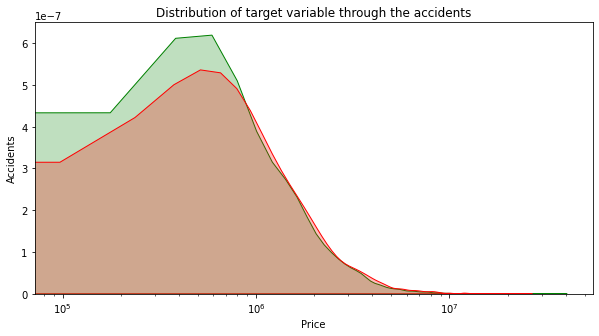

In [ ]:
df_with_accident = train_df.copy()
df_with_accident.loc[~df_with_accident.Accidents.isnull(), 'Accidents'] = 1
df_with_accident.loc[df_with_accident.Accidents.isnull(), 'Accidents'] = 0

feature_with_target_s = df_with_accident[['Accidents', TARGET_NAME]]
feature_s = feature_with_target_s[TARGET_NAME]
feature_target_0 = feature_s[feature_with_target_s['Accidents'] == 0]
feature_target_1 = feature_s[feature_with_target_s['Accidents'] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(feature_target_0, shade=True, label='no accidents', color='g')
sns.kdeplot(feature_target_1, shade=True, label='accidents', color='r')

plt.ylabel('Accidents')
plt.title('Distribution of target variable through the accidents')
plt.xscale('log')
plt.show()
# look for distribution

In [ ]:
mannwhitneyu(feature_target_0, feature_target_1)

MannwhitneyuResult(statistic=86765822.0, pvalue=1.4807609509159225e-07)

In [ ]:
colors = {num: color for color, num in zip(np.arange(train_df.Color.unique().shape[0]), train_df.Color.unique())}
train_df.Color = train_df.Color.map(colors)

In [ ]:
print(train_df.Color.value_counts(), end='\t')
train_df.groupby('Color').agg({'Price': 'mean'})

4     8548
5     6308
2     4496
8     3455
6     3123
3     1735
9     1352
0      862
13     689
12     408
11     310
7      227
10     219
14     194
1      192
15      12
Name: Color, dtype: int64	

,Price
Color,
0,8.257119e+05
1,1.508287e+06
2,1.333652e+06
3,1.084932e+06
4,1.844611e+06
5,1.503377e+06
6,1.327286e+06
7,7.987531e+05
8,8.453146e+05


In [ ]:
# some kind of frequency encoding
train_df.Color.value_counts()[0] / train_df.Color.shape[0]
#train_df.Color.apply(lambda x: train_df.Color.value_counts()[x] / train_df.Color.shape[0]).unique()
color_dict = train_df.Color.value_counts().to_dict()
train_df.Color = train_df.Color.map(color_dict) / train_df.Color.shape[0]
train_df.Color.unique()

array([0.02682851, 0.00597572, 0.13993153, 0.05399938, 0.2660442 ,
       0.19632742, 0.09719888, 0.00706505, 0.1075319 , 0.04207905,
       0.00681606, 0.0096483 , 0.01269841, 0.02144413, 0.00603797,
       0.00037348])

In [ ]:
train_df.columns

Index(['Model', 'Year', 'Mileage', 'V_engine', 'EngineType', 'HorsePower',
       'Tax', 'State', 'Owners', 'Passport', 'Customs', 'Selector', 'Color',
       'CarBodyType', 'Accidents', 'Drive', 'Price'],
      dtype='object')

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

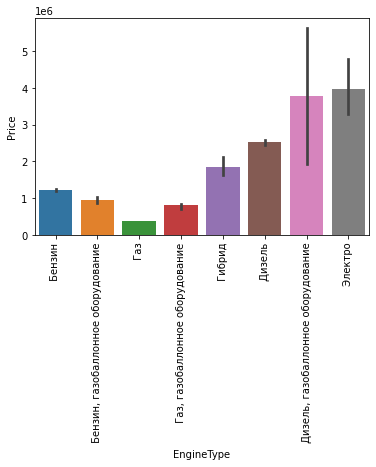

In [ ]:
sns.barplot(x=train_df.EngineType, y=train_df.Price)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text major ticklabel objects>)

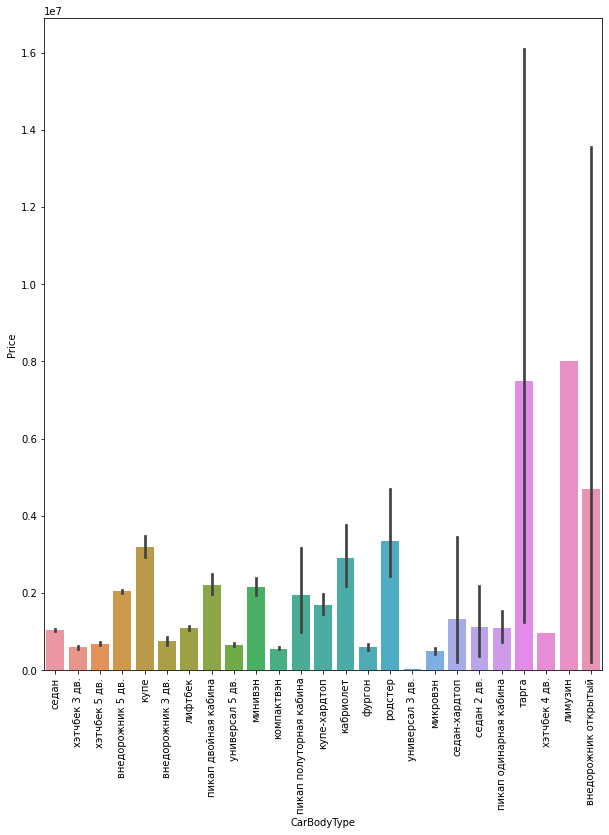

In [ ]:
plt.figure(figsize=(10,12))
sns.barplot(x=train_df.CarBodyType, y=train_df.Price)
plt.xticks(rotation=90)

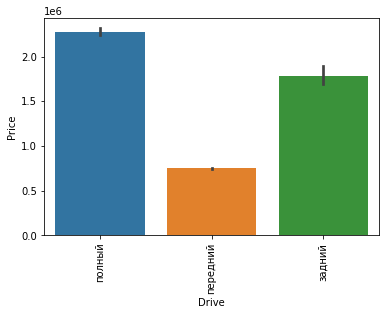

In [ ]:
sns.barplot(x=train_df.Drive, y=train_df.Price)
plt.xticks(rotation=90)
plt.show()

In [ ]:
train_df[train_df.Tax == 0]

,Model,Year,Mileage,V_engine,EngineType,HorsePower,Tax,State,Owners,Passport,Customs,Selector,Color,CarBodyType,Accidents,Drive,Price
24388,Tesla Model 3 Long Range I,2020,43000.0,258.0,Электро,351.0,0.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,0.139932,седан,NaN,полный,4500000.0
15804,Nissan Leaf I (ZE0/AZE0),2014,111300.0,80.0,Электро,109.0,0.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,0.196327,хэтчбек 5 дв.,NaN,передний,630000.0
2658,Tesla Model Y Long Range I,2021,100.0,254.0,Электро,345.0,0.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,0.196327,внедорожник 5 дв.,NaN,полный,5780000.0
27178,Tesla Model X 100D I,2017,19000.0,525.0,Электро,714.0,0.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,0.266044,внедорожник 5 дв.,NaN,полный,7700000.0
5985,Fiat 500 II,2013,75300.0,82.0,Электро,111.0,0.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,0.139932,хэтчбек 3 дв.,NaN,передний,959999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34923,Tesla Model S 70D I Рестайлинг,2016,70000.0,245.0,Электро,333.0,0.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,0.139932,лифтбек,ДТП ненайдены,полный,3750000.0
34589,Tesla Model S P85 I,2014,60000.0,310.0,Электро,422.0,0.0,Не требует ремонта,3 или более,Оригинал,Растаможен,автоматическая,0.053999,лифтбек,ДТП ненайдены,задний,3250000.0
32100,Tesla Model Y Long Range I,2021,100.0,254.0,Электро,345.0,0.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,0.139932,внедорожник 5 дв.,NaN,полный,6099000.0
2124,Tesla Model S P85+ I,2014,8500.0,350.0,Электро,470.0,0.0,Не требует ремонта,1 владелец,Оригинал,Растаможен,автоматическая,0.053999,лифтбек,NaN,задний,3650000.0


In [ ]:
train_df[train_df.Price > 25e+6]

,Year,Mileage,V_engine,HorsePower,Tax,Owners,Passport,Color,Accidents,Price,MarkModel,вариатор,механическая,роботизированная,лифтбек,минивэн,прочие,седан,универсал 5 дв.,хэтчбек 5 дв.,передний,полный,TaxPower,YearMilesPrice,YearOwnerPrice
7221,12,10.0,2.1,190.0,9.254357,1,1,0.266044,0,27900000.0,15436681.0,0,0,0,0,1,0,0,0,0,0,1,0.487071,2.290000e+05,2.225000e+05
14663,12,1.0,2.1,190.0,9.254357,1,1,0.266044,0,28700000.0,15436681.0,0,0,0,0,1,0,0,0,0,0,1,0.487071,2.290000e+06,2.225000e+06
23889,15,23.0,2.1,190.0,9.254357,1,1,0.266044,0,39990000.0,15436681.0,0,0,0,0,1,0,0,0,0,0,1,0.487071,1.542609e+05,1.567174e+05
25132,12,10.0,2.1,190.0,9.254357,1,1,0.266044,0,25900000.0,15436681.0,0,0,0,0,1,0,0,0,0,0,1,0.487071,2.290000e+05,2.225000e+05
27318,12,27.0,2.1,190.0,9.254357,1,1,0.266044,0,29800000.0,15436681.0,0,0,0,0,1,0,0,0,0,0,1,0.487071,8.481481e+04,8.240741e+04
30929,7,4800.0,6.2,591.0,11.392451,9,1,0.053999,1,26000000.0,23400500.0,0,0,1,0,0,1,0,0,0,0,0,0.192766,2.291667e+02,2.218750e+02


In [ ]:
def select_features(df, threshold=0.8, min_features=10, target=TARGET_NAME, disc=True):
    cm = np.corrcoef(df.values.T)
    cm_indices = np.triu_indices(df.columns.values.shape[0], 1)
    dict_ = {(df.columns[idx], df.columns[jdx]): abs(cm[idx, jdx]) for idx, jdx in zip(*cm_indices)}
    result, counter = set(), threshold
    while counter > 0.1:
        if len(result) >= min_features:
            break
        for k, v in sorted(dict_.items(), key=lambda x: x[1], reverse=True):
            if k[1] == target and v >= counter:
                result.add(k[0]) if k[0] != target else result.add(k[1])
        counter -= 0.1
    if disc:
        for k in dict_.keys():
            if k[1] != target and ((k[0] in result) and (k[1] in result)) \
            and (dict_.get((k[0], k[1])) >= threshold):
                try:
                    result.discard(k[0]) if dict_.get((k[0], target)) < dict_.get((k[1], target)) \
                    else result.discard(k[1])
                except TypeError:
                    pass
    final_ = list(result)
    selected_df = df[[*final_, target]]
    return selected_df

def select_corr_feature(df, threshold=0.5, target='Price', disc=True):
    X_corr = df.corr()
    X_corr_sel = X_corr.drop(target, axis=0)[target]
    high_corr = [x for x, y in zip(X_corr_sel.index, X_corr_sel) if np.abs(y) > threshold]
    if disc:
        stack, high_, removed = deque(high_corr), set(), set()
        while len(stack) > 1:
            x = stack.popleft()
            for y in stack.copy():
                if np.abs(X_corr.loc[x, y]) >= threshold:
                    if np.abs(X_corr.loc[x, target]) > np.abs(X_corr.loc[y, target]):
                        high_.add(x)
                        if y in stack:
                            stack.remove(y)
                        high_.discard(y)
                        removed.add(y)
                    else:
                        high_.add(y)
                        if x in stack:
                            stack.remove(x)
                        high_.discard(x)
                        removed.add(x)
                else:
                    if x not in removed:
                        high_.add(x)
        high_corr = list(high_)
    return df[[*high_corr, target]]

In [ ]:
# color - frequency encoding
# model - target encoding: mark+model.mean / fillna - model.mean
# year - category cut
# mileage - stay / outliers by isolation forest -> IQR
# v_engine - electro /= 100
# engine type - one hot encoding
# horsepower - stay
# tax - np.sqrt or np.log for norm distribution - calculate nans and zeros by known formula, TAX == 0??
# state - binary encoding
# owners - ? to category and one hot or just to int 1,2,3
# passport - binary encoding
# customs - binary encoding
# selector - one hot for non-catboost
# carbodytype - frequency or target encoding / union (if mean price of cat is equal) and one-hot (woe if there was classifiacation task) / dummie and decomposition
# accidents - binary encoding
# drive - one hot

# issusp, isnan, add target encoding with complex grouping year-mileage-price year-owners-target tax/horsepower
## do not use one hot for catboost

# learning curve for best data split
# plot results, metrics, validation
# feature importancies (RF, GB), correlation, mutual and selection
# base model: linearregression
# xgbm, lgbm, catboost regressors

In [ ]:
class Preprocessor:

    def __init__(self, target=TARGET_NAME, with_cat=False):
        self.target = target
        self.with_cat = with_cat
        self.means = None
        self.medians = None
        self.modes = None
        self.stds = None
        self.Q1 = None
        self.Q3 = None
        self.owner_probas = None
        self.color_dict = None
        self.mark_models = None
        self.models = None
        self.year_bins = None
        self.year_miles_price = None
        self.year_miles_price_med = None
        self.owners_year_price = None
        self.owners_year_price_med = None

    def __call__(self, df):
        if self.target in df.columns:
            self.fit(df)
        df = self.transform(df)
        df = self.create_features(df)
        df = self.reduce_memory(df)
        return df

    def fit(self, df):
        self.means = df.mean()
        self.medians = df.median()
        self.modes = df.mode()
        self.stds = df.std()
        self.Q1 = np.quantile(df.Mileage, q=0.25)
        self.Q3 = np.quantile(df.Mileage, q=0.75)
        self.owner_probas = df.Owners.value_counts().apply(lambda x: x / df[~df.Owners.isnull()].shape[0]).to_list()
        self.color_dict = df.Color.value_counts().to_dict()
        self.year_bins = np.linspace(df.Year.min(), df.Year.max(), num=35).astype(int)

    def transform(self, df):
        # constant variables / duplicates
        df.drop_duplicates(inplace=True)
        df = df.drop(['State', 'Customs'], axis=1)

        # outliers
        upper_mile_border = self.Q3 + 1.5 * (self.Q3 - self.Q1)
        df.Mileage = np.clip(df.Mileage, 0, upper_mile_border)

        df.loc[df.EngineType == 'Электро', 'V_engine'] /= 100

        # nans in tax, with no respect to tax on luxary
        condition = ((df.HorsePower <= 100) & (df.Tax.isna()))
        df.loc[condition, 'Tax'] = df.loc[condition, 'HorsePower'] * 2.5
        condition = ((df.HorsePower.between(101, 150)) & (df.Tax.isna()))
        df.loc[condition, 'Tax'] = df.loc[condition, 'HorsePower'] * 3.5
        condition = ((df.HorsePower.between(151, 200)) & (df.Tax.isna()))
        df.loc[condition, 'Tax'] = df.loc[condition, 'HorsePower'] * 5
        condition = ((df.HorsePower.between(201, 250)) & (df.Tax.isna()))
        df.loc[condition, 'Tax'] = df.loc[condition, 'HorsePower'] * 7.5
        condition = ((df.HorsePower > 250) & (df.Tax.isna()))
        df.loc[condition, 'Tax'] = df.loc[condition, 'HorsePower'] * 15

        df.loc[df.Owners.isna(), 'Owners'] = np.random.choice(df.Owners.dropna(axis=0).unique(),
                                                              p=self.owner_probas, size=df[df.Owners.isna()].shape[0])

        # df.Customs.fillna(self.modes.Customs[0], inplace=True) # dropped earlier

        df.loc[~df.Accidents.isna(), 'Accidents'] = 1
        df.Accidents.fillna(0, inplace=True)
        df.Accidents = df.Accidents.astype(np.uint8)

        # Color frequency encoding
        df.Color = df.Color.map(self.color_dict) / df.Color.shape[0]
        df.Color.fillna(self.modes.Color[0], inplace=True)

        # Model target encoding, mean (not median) because of no outliers
        df['MarkModel'] = df.Model.apply(lambda x: ' '.join(x.split()[:3]))
        if self.target in df.columns:
            self.mark_models = df.groupby('MarkModel').agg({self.target: 'mean'}).to_dict()[self.target]
        df['MarkModel'] = df['MarkModel'].map(self.mark_models)

        # year category cuts and log scale
        #df.Year = np.log(pd.cut(train_df.Year, bins=year_bins, labels=False) + 1e-5)
        df.loc[df.Year < 1981, 'Year'] = 11
        df.loc[df.Year == 2021, 'Year'] = 15
        df.loc[df.Year.between(2018, 2020), 'Year'] = 12
        df.loc[df.Year.between(2016, 2017), 'Year'] = 9
        df.loc[df.Year.between(2012, 2015), 'Year'] = 7
        df.loc[df.Year.between(2008, 2011), 'Year'] = 5
        df.loc[df.Year.between(1995, 2007), 'Year'] = 3
        df.loc[df.Year.between(1981, 1994), 'Year'] = 1

        # log for Tax?
        df.Tax = np.log(df.Tax + 1e-5)

        # Owners category + one-hot? / here to int 1, 4, 9 ??
        df.Owners = np.square(df.Owners.apply(lambda x: x.split()[0]).astype(np.float16))
        df.Owners = df.Owners.astype(np.uint8)

        # Price outliers?
        """
        if self.target in df.columns:
            qmax = np.quantile(df[self.target], q=0.999)
            df.loc[df[self.target] > 25e+6, self.target] = qmax
        """

        if not self.with_cat:
            df = df.drop('Model', axis=1)

            # EnigineType one-hot encoding
            vals = ['Бензин', 'Дизель', 'Гибрид', 'Электро']
            df.loc[~df.EngineType.isin(vals), 'EngineType'] = 'Газ'
            EngineDummy = pd.get_dummies(df.EngineType, drop_first=True)
            dummy_size = EngineDummy.shape[1]
            df = pd.concat([df, EngineDummy], axis=1)
            del EngineDummy
            df.iloc[:, -dummy_size] = df.iloc[:, -dummy_size].astype(np.uint8)
            df.drop('EngineType', axis=1, inplace=True)

            # passport binary encoding / labelencoding
            df.Passport = df.Passport.map({'Оригинал': 1, 'Дубликат': 0})
            df.Passport = df.Passport.astype(np.uint8)

            # selector one-hot
            Selector_dummy = pd.get_dummies(df.Selector, drop_first=True)
            dummy_size = Selector_dummy.shape[1]
            df = pd.concat([df, Selector_dummy], axis=1)
            del Selector_dummy
            df.iloc[:, -dummy_size] = df.iloc[:, -dummy_size].astype(np.uint8)
            df.drop('Selector', axis=1, inplace=True)

            # carbodytype: union and onehot
            vals = ['внедорожник 5 дв.', 'седан', 'хэтчбек 5 дв.', 'лифтбек', 'универсал 5 дв.', 'минивэн']
            df.loc[df.CarBodyType == 'компактвэн', 'CarBodyType'] = 'минивэн'
            df.loc[~df.CarBodyType.isin(vals), 'CarBodyType'] = 'прочие'
            CBType_dummy = pd.get_dummies(df.CarBodyType, drop_first=True)
            dummy_size = CBType_dummy.shape[1]
            df = pd.concat([df, CBType_dummy], axis=1)
            del CBType_dummy
            df.iloc[:, -dummy_size] = df.iloc[:, -dummy_size].astype(np.uint8)
            df.drop('CarBodyType', axis=1, inplace=True)

            #  drive one-hot encoding
            df = pd.concat([df, pd.get_dummies(df.Drive, drop_first=True)], axis=1)
            df.iloc[:, -2] = df.iloc[:, -2].astype(np.uint8)
            df.drop('Drive', axis=1, inplace=True)

            # nans in MarkModel using IterativeImputer
            df = self.IterativeInput(df) 
        else:
            # nans in MarkModel using means from aditional column
            df['MarkOnly'] = df.Model.apply(lambda x: ''.join(x.split()[0]))
            df = df.drop('Model', axis=1)
            if self.target in df.columns:
                self.models = df.groupby('MarkOnly').agg({TARGET_NAME: 'median'}).to_dict()[TARGET_NAME]
            df['MarkOnly'] = df['MarkOnly'].map(self.models)
            df['MarkOnly'].fillna(self.medians.Price, inplace=True)  
            df.loc[df.MarkModel.isna(), 'MarkModel'] = df.loc[df.MarkModel.isna(), 'MarkOnly']
            df.drop('MarkOnly', axis=1, inplace=True)

        return df

    def create_features(self, df):
        # Tax / HorsePower 
        df['TaxPower'] = df.Tax / df.HorsePower * 10
        # year med price / mileage
        if self.target in df.columns:
            self.year_miles_price = df.groupby('Year').agg({self.target: 'median'}).to_dict()[self.target]
            df['YearMilesPrice'] = df.Year.map(self.year_miles_price) / df.Mileage
            self.year_miles_price_med = df['YearMilesPrice'].median()
        else:
            df['YearMilesPrice'] = df.Year.map(self.year_miles_price) / df.Mileage
            df['YearMilesPrice'].fillna(self.year_miles_price_med, inplace=True)
        # year-owners-price
        if self.target in df.columns:
            self.owners_year_price = df.groupby(['Year', 'Owners'], as_index=False).agg({self.target: 'median'})
            self.owners_year_price_med = self.owners_year_price[self.target].mean()
            self.owners_year_price.rename(columns={self.target: 'YearOwnerPrice'}, inplace=True)
        df = df.merge(self.owners_year_price, on=['Year', 'Owners'], how='left')
        df.YearOwnerPrice.fillna(self.owners_year_price_med, inplace=True)
        df.YearOwnerPrice = df.YearOwnerPrice / df.Mileage

        return df

    def IterativeInput(self, df):
        columns = df.columns.copy()
        uint_columns = df.select_dtypes(['uint8']).columns
        int_columns = df.select_dtypes(['int64']).columns
        imputer = IterativeImputer(max_iter=30, imputation_order='roman', random_state=1)
        df = imputer.fit_transform(df)
        df = pd.DataFrame(df, columns=columns)
        df[uint_columns] = df[uint_columns].astype(np.uint8)
        df[int_columns] = df[int_columns].astype(np.int16)
        return df

    def get_outliers(self, serie, contamination=1e-5):
        iso = IsolationForest(n_estimators=100, contamination=contamination, n_jobs=-1, random_state=1)
        outlier = iso.fit_predict(serie.values.reshape(-1, 1))
        return outlier

    @staticmethod
    def reduce_memory(df):
        start_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
        for col in df.columns:
            col_type = df[col].dtype
            if col_type != object and str(col_type)[:4] != 'uint':
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
            elif str(col_type)[:4] != 'uint':
                df[col] = df[col].astype('category')
        end_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        return df


In [ ]:
train_df, test_df_with_price = train_test_split(df, test_size=0.1, shuffle=True, random_state=1)
test_df, test_targets = test_df_with_price.drop(TARGET_NAME, axis=1), test_df_with_price.Price
test_df = test_df.append(volvo)
preprocessor = Preprocessor(with_cat=False)
train_df = preprocessor(train_df)
test_df = preprocessor(test_df)

Memory usage of dataframe is 3.16 MB
Memory usage after optimization is: 1.93 MB
Decreased by 38.8%
Memory usage of dataframe is 0.33 MB
Memory usage after optimization is: 0.20 MB
Decreased by 38.1%


In [ ]:
X, y = train_df.drop(TARGET_NAME, axis=1), train_df[TARGET_NAME]

In [ ]:
# learning curve
# train_test_split
# plot results, metrics, validation

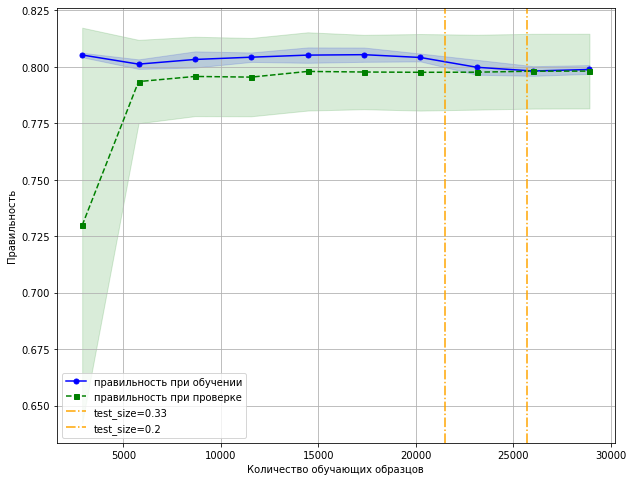

In [ ]:
estimator = make_pipeline(StandardScaler(), LinearRegression())
train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X, y=y, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, scoring='r2', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='правильность при обучении')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='правильность при проверке')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.axvline(X.shape[0]*0.67, color='orange', linestyle='-.', label='test_size=0.33')
plt.axvline(X.shape[0]*0.8, color='orange', linestyle='-.', label='test_size=0.2')
plt.grid()
plt.xlabel('Количество обучающих образцов')
plt.ylabel('Правильность')
plt.legend(loc='best')
plt.show()
# оптимальный test_size=0.2

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

In [ ]:
# feature importancies (GB), correlation, lasso, mutual and selection
# base model: linearregression

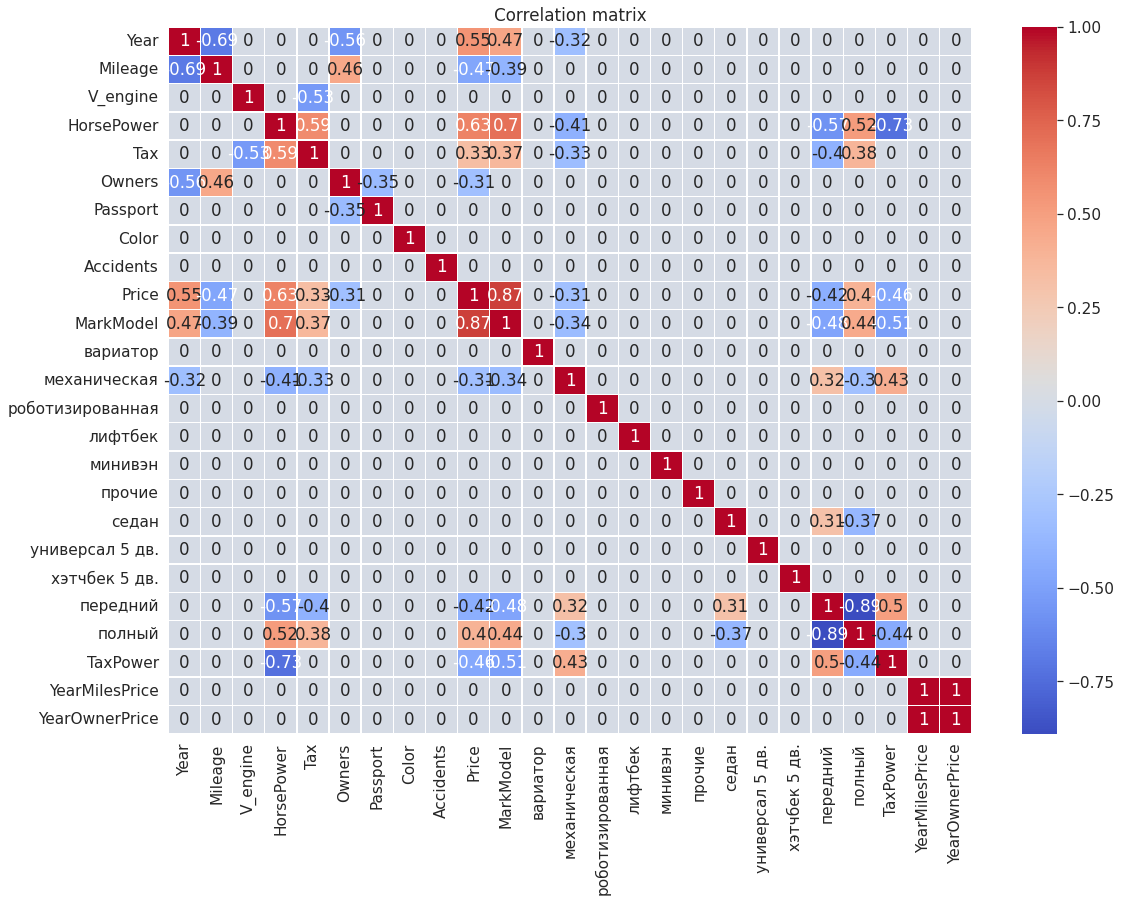

In [ ]:
plt.figure(figsize = (18,13))
sns.set(font_scale=1.4)
corr_matrix = train_df.corr(method='pearson')
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

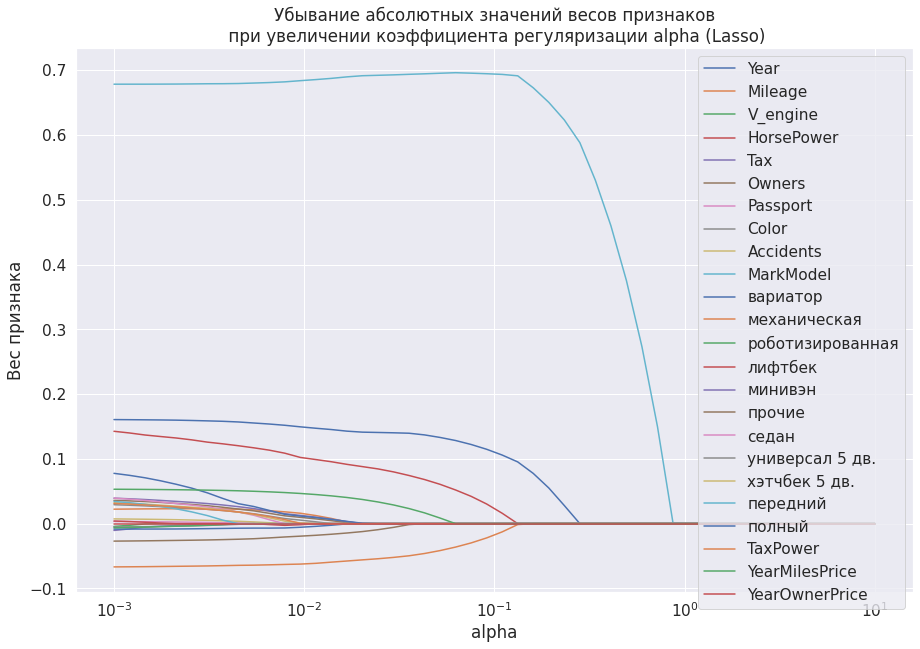

In [ ]:
n = 50
cols = train_df.drop(TARGET_NAME, axis=1).columns.to_list()
len_features = len(cols)
coeffs = np.zeros((n, len_features))
sc_x, sc_y = StandardScaler(), StandardScaler()
X_std, y_std = sc_x.fit_transform(X), sc_y.fit_transform(y[:, np.newaxis]).flatten()
X_scaled = pd.DataFrame(X_std, columns=cols)
alpha_list = np.logspace(-3, 1, n)

for i, val in enumerate(alpha_list):
    lasso = Lasso(alpha=val)
    lasso.fit(X_scaled, y_std)
    
    coeffs[i, :] = lasso.coef_.flatten()
plt.figure(figsize=(15, 10))
for i in range(len_features):
    plt.plot(alpha_list, coeffs[:, i])

plt.title('Убывание абсолютных значений весов признаков\n при увеличении коэффициента регуляризации alpha (Lasso)')

plt.xlabel('alpha')
plt.ylabel('Вес признака')
plt.legend(cols, loc='upper right')
plt.xscale('log')
plt.show()

In [ ]:
# MarkModel, Year, HorsePower/TaxPower

In [ ]:
mutual_vector = mutual_info_regression(X, y, random_state=1)

In [ ]:
mutual_dict = dict(zip(X.columns, mutual_vector))
for col, vec in sorted(mutual_dict.items(), key=lambda x: x[1], reverse=True):
    print(f'{col} -> {vec}')

MarkModel -> 1.4028582416551112
HorsePower -> 0.8505799204153766
TaxPower -> 0.7558234099046999
Tax -> 0.7332566032992087
Year -> 0.5530857840918686
V_engine -> 0.4663721400734815
YearMilesPrice -> 0.4425715944357349
YearOwnerPrice -> 0.4398290712659101
Mileage -> 0.36059701089466145
передний -> 0.2617128474314221
механическая -> 0.247910516975006
Color -> 0.23613309908345048
Owners -> 0.23187928721643125
полный -> 0.23158964216187305
седан -> 0.11353220911287565
хэтчбек 5 дв. -> 0.102056887256738
Passport -> 0.09677420379456825
вариатор -> 0.09370344949642417
Accidents -> 0.09338646913331017
роботизированная -> 0.08974522439135812
прочие -> 0.08070700167850742
лифтбек -> 0.07683468810767513
универсал 5 дв. -> 0.0763150579315881
минивэн -> 0.06447805376988791


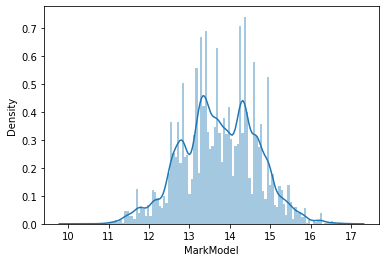

In [ ]:
sns.distplot(np.log(train_df.MarkModel), bins=120)
plt.show()

1) MarkModel	0.25815078350081744
2) YearMilesPrice	0.12976945961040218
3) TaxPower	0.1116925616914735
4) Year	0.08511897463531527
5) YearOwnerPrice	0.08078688699442521
6) HorsePower	0.08021225664557685
7) Tax	0.06773326162547892
8) V_engine	0.059786268135263915
9) Mileage	0.05697358847773082
10) передний	0.020112424544052473
11) полный	0.0174770508469814
12) Owners	0.013657784156533532
13) механическая	0.0066286443963955045
14) Color	0.0038538610751554917
15) седан	0.0029533247802350044
16) минивэн	0.0015726887476387125
17) вариатор	0.0010646250616531594
18) Passport	0.0007978249623594054
19) роботизированная	0.0005827010149835966
20) хэтчбек 5 дв.	0.0004688956401306228
21) прочие	0.0003786207433310775
22) лифтбек	0.00010590131464560887
23) Accidents	7.695738623837147e-05
24) универсал 5 дв.	4.4654013181891474e-05


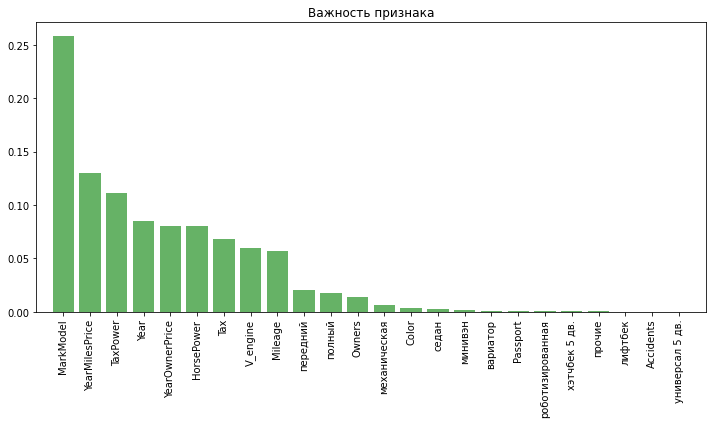

In [ ]:
boost = GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=60, 
                                  random_state=1, n_estimators=500, tol=1e-2, warm_start=True,
                                  max_features='sqrt', loss='huber', learning_rate=0.02)
boost.fit(X, y)
feat_labels = np.array(train_df.drop(TARGET_NAME, axis=1).columns)
importances = boost.feature_importances_
indices = np.argsort(importances)[::-1]
for x in range(X.shape[1]):
    print(f'{x+1}) {feat_labels[indices[x]]}\t{importances[indices[x]]}')
plt.figure(figsize=(10, 6))
plt.title('Важность признака')
plt.bar(range(X.shape[1]), importances[indices], align='center', alpha=0.6, color='green')
plt.xticks(range(X.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

In [ ]:
class ChooseBestSubset:
    def __init__(self, estimator, k_features, scoring='r2_score', test_size=0.25, random_state=1):
        self.scoring = str(scoring)
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        if (self.scoring == 'r2_score') or (self.scoring == 'mse'):
            self.scoring = eval(self.scoring)
        else:
            raise ValueError(f'Метрика должна быть "r2_score" или "mse", дана: {self.scoring}')
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, 
                                                           random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_) # сначала для полного набора
        self.scores_ = [score]
        while dim > self.k_features: # цикл до тех пор, пока не будет наименее короткий заданный набор
            scores, subsets = [], []
            sys.stderr.write(f'Анализ наборов признаков {dim}/{X_train.shape[1]}, осталось {dim - self.k_features}:')
            for p in tqdm(combinations(self.indices_, r=dim-1), total=dim): # проверяем различные комбинации признаков 
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score) # записываем score текущего набора
                subsets.append(p) # записываем значения индексов текущего набора
            clear_output(wait=True)
            best = np.argmax(scores) if self.scoring == r2_score else np.argmin(scores) # находим лучший набор
            self.indices_ = subsets[best] # сохраняем значения индексов лучшего набора из текущей итерации while
            self.subsets_.append(self.indices_) # сохраняем лучший набор из текущей итерации while
            dim -= 1
            self.scores_.append(scores[best]) # сохраняем лучшее значение метрики на текущей итерации
        self.k_score_ = self.scores_[-1] # scores для последнего набора = k_features
        return self
    def _calc_score(self, X_train, y_train, X_test, y_test, indices): # вычисляем метрику набора
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [ ]:
selector = ChooseBestSubset(estimator, k_features=10, test_size=0.2)
selector.fit(X.values, y)

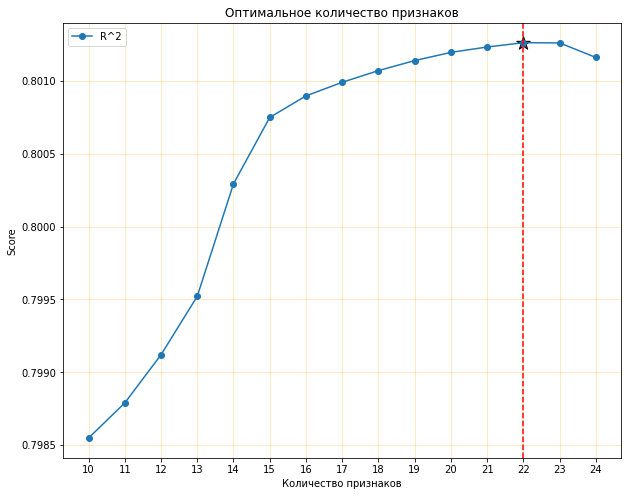

In [ ]:
k_feat = [len(k) for k in selector.subsets_] 
plt.figure(figsize=(10, 8))
plt.plot(k_feat, selector.scores_, marker='o', label='R^2')
plt.scatter(k_feat[np.argmax(np.array(selector.scores_))], max(selector.scores_), marker='*', color='red', 
              ec='black', s=200)
plt.axvline(k_feat[np.argmax(np.array(selector.scores_))], color='red', linestyle='--')
plt.title('Оптимальное количество признаков')
plt.ylabel('Score')
plt.xlabel('Количество признаков')
plt.legend(loc='best')
plt.xticks(k_feat)
plt.grid(color='orange', alpha=0.3) 
plt.show()

In [ ]:
columns = train_df.columns[train_df.columns != TARGET_NAME]
cols = [columns[i] for i in selector.subsets_[np.argmax(np.array(selector.scores_))]]
cols += [TARGET_NAME]
df_selected_cbs = train_df[[*cols]]
df_selected_cbs.head(1)

,Year,Mileage,V_engine,HorsePower,Tax,Owners,Color,Accidents,MarkModel,вариатор,механическая,лифтбек,минивэн,прочие,седан,универсал 5 дв.,хэтчбек 5 дв.,передний,полный,TaxPower,YearMilesPrice,YearOwnerPrice,Price
0,9,107191.0,3.0,249.0,9.834941,9,0.026829,1,5472988.5,0,0,0,0,0,1,0,0,0,1,0.394978,15.635641,16.960379,4199000.0


In [ ]:
X, y = df_selected_cbs.drop(TARGET_NAME, axis=1), df_selected_cbs[TARGET_NAME]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=1)

R2:	0.798
MAE:	376478.75
RMSE:	776127.06
MSE:	602373200000.0
MSE_scaled:	685293.75


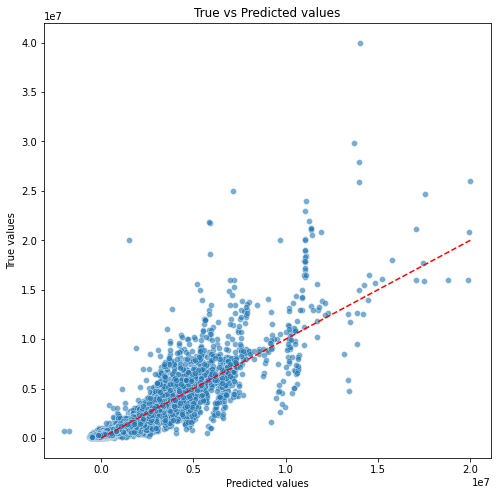

R2:	0.801
MAE:	388617.75
RMSE:	787029.0
MSE:	619414600000.0
MSE_scaled:	711970.8


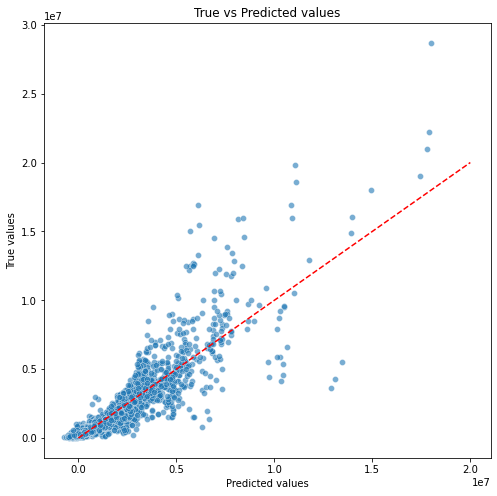

In [ ]:
estimator.fit(X_train, y_train)
y_train_pred = estimator.predict(X_train)
y_valid_pred = estimator.predict(X_valid)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_valid, y_valid_pred)

In [ ]:
scores = cross_validation(estimator, X_train, y_train)

Меры правильности перекрекстной оценки: [0.82205896 0.81052016 0.78758913 0.76072224 0.82658114 0.75813055
 0.76224713 0.80444525 0.80310319 0.82723492]
Точность перекретсной оценки: 0.796 +/- 0.026


In [ ]:
# xgbm, lgbm, catboost regressors (categorical features == np.uint8, object) + metrics, validation
# voting
# split dataset on few subsets and train them separatly / on real data: preprocess, send to submodel
# evaluate on test_df

R2:	0.881
RMSE:	595989.097
MSE:	355203003285.878
MSE_scaled:	404098.98


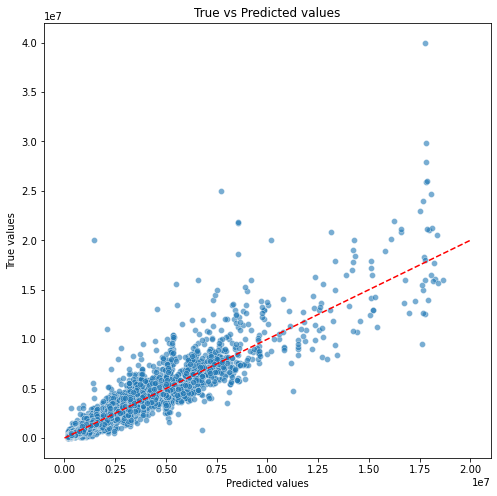

R2:	0.879
RMSE:	615196.265
MSE:	378466444093.715
MSE_scaled:	435018.901


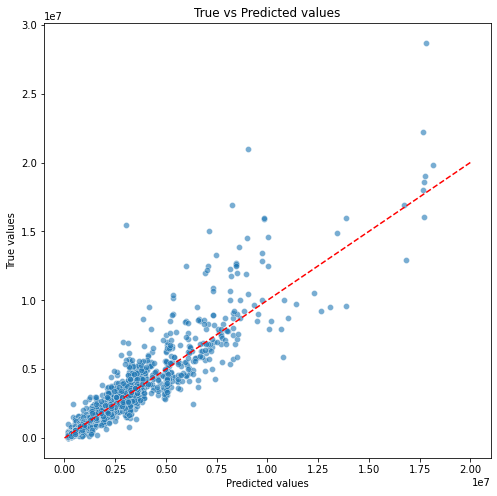

In [ ]:
rf = RandomForestRegressor(n_estimators=150, criterion='mse', max_depth=5, max_features=22, min_samples_leaf=15, 
                           min_samples_split=2, random_state=1)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_valid_pred = rf.predict(X_valid)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_valid, y_valid_pred)

R2:	0.932
MAE:	214341.53
RMSE:	451432.2
MSE:	203791000000.0
MSE_scaled:	231844.16


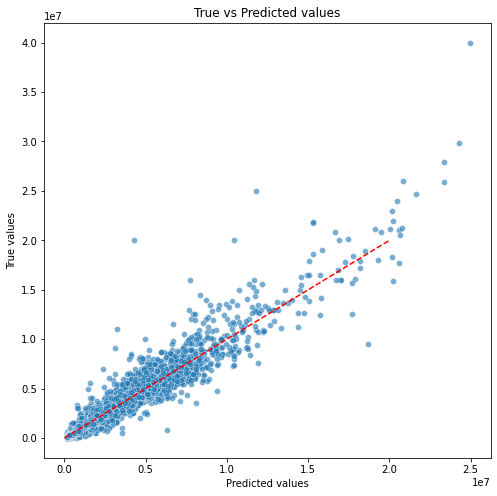

R2:	0.921
MAE:	224996.3
RMSE:	497220.72
MSE:	247228430000.0
MSE_scaled:	284170.62


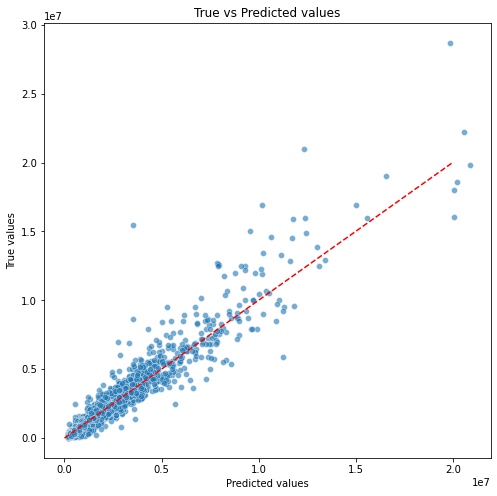

In [ ]:
xgreg = XGBRegressor(max_depth=4, learning_rate=0.01, n_estimators=550, booster='gbtree', subsample=0.3, 
                     colsample_bytree=0.9, random_state=1, gamma=0, objective='reg:squarederror')
xgreg.fit(X_train, y_train)
y_train_pred = xgreg.predict(X_train)
y_valid_pred = xgreg.predict(X_valid)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_valid, y_valid_pred)

In [ ]:
xgboost_final = xgreg.predict(test_df[X_train.columns.to_list()])

R2:	0.933
MAE:	236359.439
RMSE:	470036.376
MSE:	220934194968.3
MSE_scaled:	256900.227


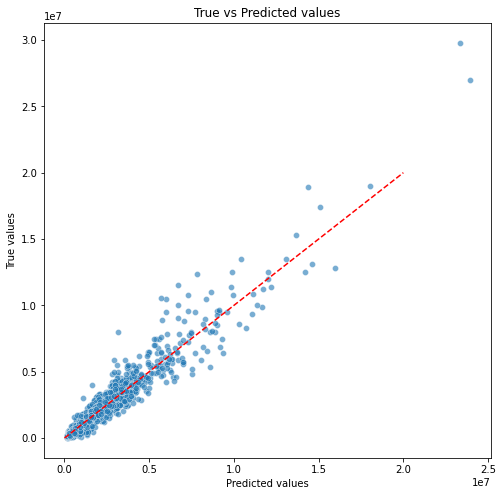

In [ ]:
evaluate_preds(test_targets, xgboost_final)

R2:	0.924
RMSE:	476845.446
MSE:	227381579027.689
MSE_scaled:	258682.115


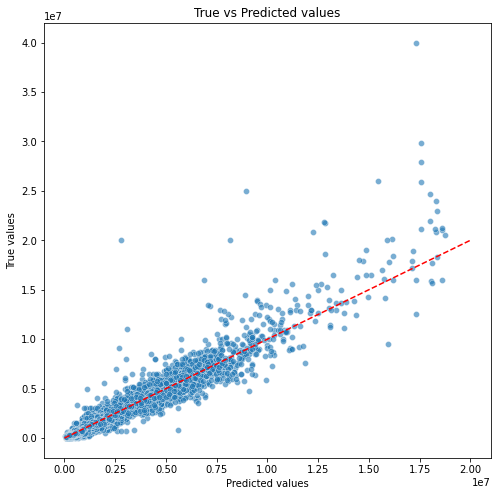

R2:	0.909
RMSE:	532240.725
MSE:	283280189260.199
MSE_scaled:	325609.413


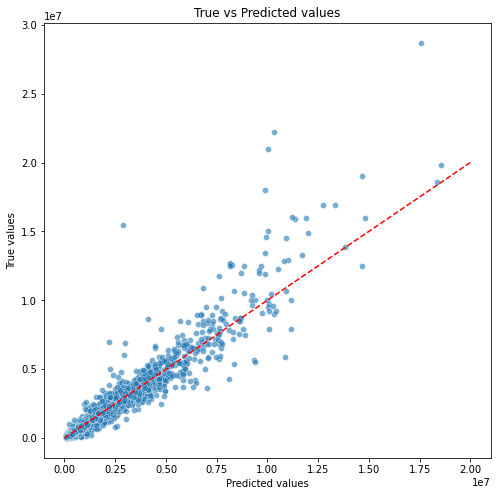

In [ ]:
lgbreg = LGBMRegressor(boosting_type='goss', num_leaves=65, max_depth=6, learning_rate=0.01, n_estimators=660,
                       subsample=0.8, colsample_bytree=0.3, random_state=1, reg_lambda=5., metric='mse')
lgbreg.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=10, verbose=False)
y_train_pred = lgbreg.predict(X_train)
y_valid_pred = lgbreg.predict(X_valid)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_valid, y_valid_pred)

In [ ]:
train_df, test_df_with_price = train_test_split(df, test_size=0.1, shuffle=True, random_state=1)
test_df, test_targets = test_df_with_price.drop(TARGET_NAME, axis=1), test_df_with_price.Price
preprocessor = Preprocessor(with_cat=True)
train_df = preprocessor(train_df)
test_df = preprocessor(test_df)

Memory usage of dataframe is 4.23 MB
Memory usage after optimization is: 1.72 MB
Decreased by 59.4%
Memory usage of dataframe is 0.44 MB
Memory usage after optimization is: 0.18 MB
Decreased by 59.7%


In [ ]:
X, y = train_df.drop(TARGET_NAME, axis=1), train_df[TARGET_NAME]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)

R2:	0.943
MAE:	174882.2
RMSE:	412489.032
MSE:	170147201759.022
MSE_scaled:	193569.058


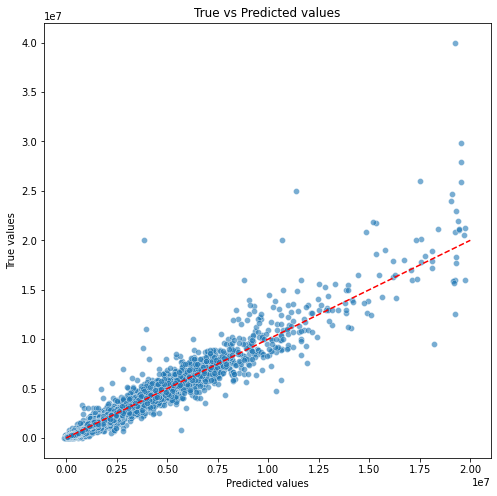

R2:	0.925
MAE:	198305.367
RMSE:	484409.324
MSE:	234652393086.501
MSE_scaled:	269715.394


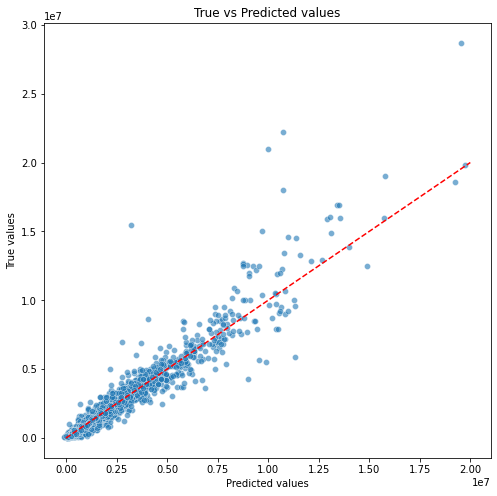

In [ ]:
lgbreg = LGBMRegressor(boosting_type='goss', num_leaves=65, max_depth=6, learning_rate=0.05, n_estimators=850,
                       subsample=0.8, colsample_bytree=0.3, random_state=1, reg_lambda=200., metric='mse')
cat_columns = X_train.select_dtypes(['int8', 'uint8', 'category']).columns
cat_features = [i for i in range(X.shape[1]) if X.columns[i] in cat_columns]
lgbreg.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=10, verbose=False, 
           categorical_feature='auto')
y_train_pred = lgbreg.predict(X_train)
y_valid_pred = lgbreg.predict(X_valid)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_valid, y_valid_pred)

In [ ]:
lgbm_final = lgbreg.predict(test_df)

R2:	0.933
MAE:	209377.37
RMSE:	468792.109
MSE:	219766041440.858
MSE_scaled:	255541.909


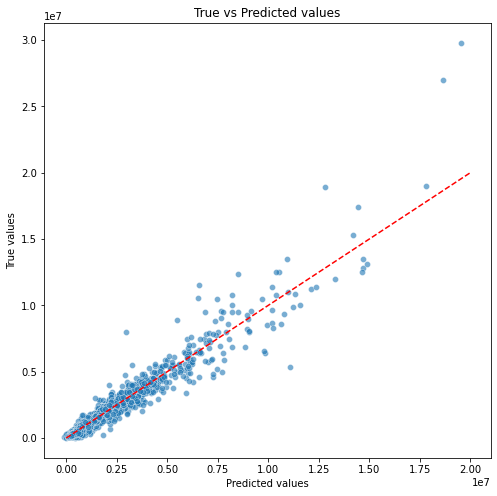

In [ ]:
evaluate_preds(test_targets, lgbm_final)

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=cat_columns.to_list()) 
test_pool = Pool(X_valid, y_valid, cat_features=cat_columns.to_list())
params_model = {
    'eval_metric': 'R2',
    'silent': True,
    'one_hot_max_size': 10,
    'early_stopping_rounds': 10,
    'boosting_type': 'Ordered',
    'allow_writing_files': False,
    'random_seed': 1
}

In [ ]:
catboost = CatBoostRegressor(**params_model)

params_grid = {
    'depth': [4, 5, 6, 7],
    'learning_rate': [0.01, 0.03, 0.1, 0.3, 0.5],
    'iterations': [200, 400, 600, 800],
    'l2_leaf_reg': [2, 2.5, 3, 3.5, 4, 5],
    'bagging_temperature': [1, 1.5, 2, 3.5],
    'subsample': [None, 0.3, 0.5, 0.8],
}
gs = catboost.randomized_search(params_grid, train_pool, n_iter=50, shuffle=True, stratified=True,
                                 partition_random_seed=1, cv=5)

In [ ]:
gs['params']

{'bagging_temperature': 1,
 'depth': 6,
 'iterations': 200,
 'l2_leaf_reg': 2,
 'learning_rate': 0.3,
 'subsample': 0.3}

R2:	0.958
MAE:	180448.231
RMSE:	351476.883
MSE:	123535999234.642
MSE_scaled:	140541.524


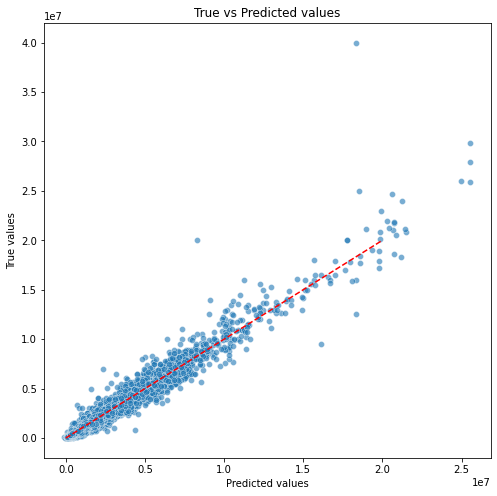

R2:	0.93
MAE:	204982.346
RMSE:	467829.528
MSE:	218864467399.588
MSE_scaled:	251568.353


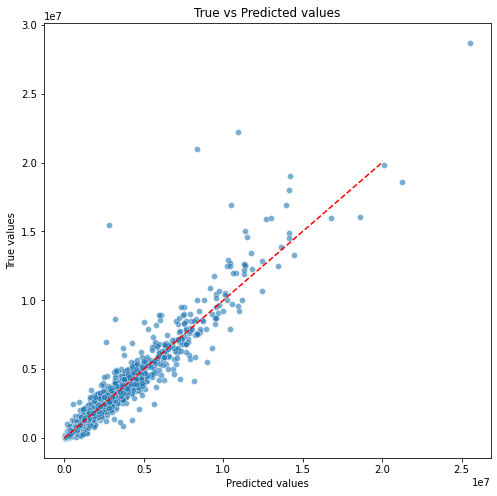

In [ ]:
cat = CatBoostRegressor(**params_model, depth=6, iterations=200, learning_rate=0.3, l2_leaf_reg=2.,
                        bagging_temperature=1., subsample=0.3)
#cat = CatBoostRegressor(**params_model, depth=4, iterations=200, learning_rate=0.3, l2_leaf_reg=2.,
#                        bagging_temperature=1., subsample=0.1)
cat.fit(train_pool, eval_set=test_pool)
y_train_pred = cat.predict(X_train)
y_valid_pred = cat.predict(X_valid)
evaluate_preds(y_train, y_train_pred)
evaluate_preds(y_valid, y_valid_pred)

R2:	0.937
MAE:	218150.81
RMSE:	440604.247
MSE:	194132102384.091
MSE_scaled:	220510.052


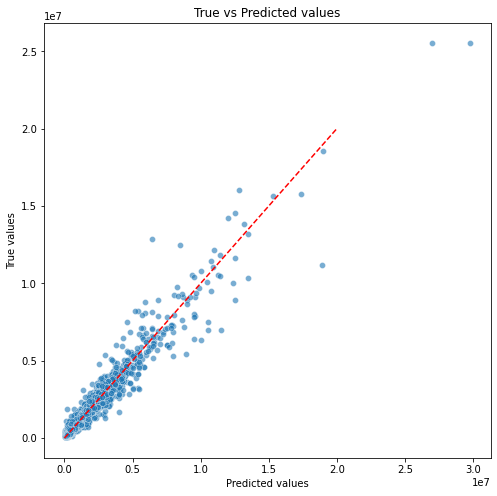

In [ ]:
# voting
final_cat = cat.predict(test_df)
evaluate_preds(final_cat, test_df_with_price[TARGET_NAME])

In [ ]:
predictions = [xgboost_final, lgbm_final, final_cat]

In [ ]:
def average_prediction(predictions: list):
  predictions = np.asarray(predictions).T
  maj_vote = np.apply_along_axis(lambda x: np.mean(x), axis=1, arr=predictions)
  return maj_vote

In [ ]:
ave_preds = average_prediction(predictions)

R2:	0.944
MAE:	207951.299
RMSE:	429481.492
MSE:	184454351881.846
MSE_scaled:	214481.805


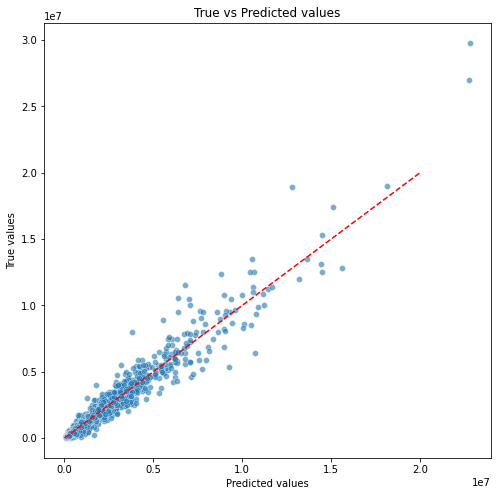

In [ ]:
evaluate_preds(test_targets, ave_preds)

In [ ]:
cross_validation(lgbreg, X_train, y_train, scoring='r2')

Меры правильности перекрекстной оценки: [0.63655879 0.92356208 0.92166978 0.86481845 0.94320444 0.9006368
 0.89614972 0.89175454 0.93842011 0.89653249]
Точность перекретсной оценки: 0.881 +/- 0.085


array([0.63655879, 0.92356208, 0.92166978, 0.86481845, 0.94320444,
       0.9006368 , 0.89614972, 0.89175454, 0.93842011, 0.89653249])

In [ ]:
from catboost import cv
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
params = {"iterations": 1000,
          "depth": 6,
          "loss_function": "MAE",
          "verbose": False}
cv(train_pool, params, fold_count=5, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 192330.368
bestIteration = 999

Training on fold [1/5]

bestTest = 190560.3023
bestIteration = 999

Training on fold [2/5]

bestTest = 189796.5003
bestIteration = 999

Training on fold [3/5]

bestTest = 184838.4929
bestIteration = 998

Training on fold [4/5]

bestTest = 197409.8122
bestIteration = 999



,iterations,test-MAE-mean,test-MAE-std,train-MAE-mean,train-MAE-std
0,0,1.370842e+06,17462.663137,1.370835e+06,4252.962401
1,1,1.335745e+06,17122.466047,1.335738e+06,4169.885621
2,2,1.310563e+06,17179.312555,1.310554e+06,4105.238783
3,3,1.275697e+06,16862.223896,1.275693e+06,3972.050543
4,4,1.246406e+06,16722.843783,1.246368e+06,3899.513826
...,...,...,...,...,...
995,995,1.910724e+05,4540.395562,1.709151e+05,1041.722166
996,996,1.910562e+05,4554.420996,1.708863e+05,1045.366228
997,997,1.910337e+05,4554.162745,1.708361e+05,1041.498954
998,998,1.910185e+05,4547.979442,1.708109e+05,1044.807655


In [ ]:
output.disable_custom_widget_manager()

In [ ]:
X_train.head()

,Year,Mileage,V_engine,EngineType,HorsePower,Tax,Owners,Passport,Selector,Color,CarBodyType,Accidents,Drive,MarkModel,TaxPower,YearMilesPrice,YearOwnerPrice
16179,5,199000.0,2.8,Бензин,204.0,9.492507,4,Оригинал,роботизированная,0.266044,лифтбек,0,полный,1.931143e+06,0.465319,3.216080,3.266332
17413,5,107300.0,2.3,Бензин,238.0,9.789759,9,Дубликат,автоматическая,0.196327,внедорожник 5 дв.,0,полный,7.125631e+05,0.411334,5.964585,5.745573
23062,7,67548.0,2.0,Бензин,150.0,8.565984,1,Оригинал,автоматическая,0.042079,седан,1,передний,1.047220e+06,0.571066,16.284716,16.654823
20753,7,22956.0,1.5,Бензин,105.0,7.872836,4,Оригинал,автоматическая,0.266044,седан,1,передний,4.657000e+05,0.749794,47.917755,48.788986
7819,12,43000.0,2.1,Дизель,163.0,8.900413,1,Оригинал,автоматическая,0.266044,минивэн,0,полный,1.543668e+07,0.546038,53.255814,51.744186


In [ ]:
data = ['Volvo XC70 II', 2012, 210000, 2.4, 'Дизель', 215, 12000, np.nan, '1 владелец', 'Оригинал', np.nan, 'автоматическая', 'коричневый', 'универсал 5 дв.', 1, 'полный']
cols = ['Model', 'Year', 'Mileage', 'V_engine', 'EngineType', 'HorsePower',
       'Tax', 'State', 'Owners', 'Passport', 'Customs', 'Selector', 'Color','CarBodyType', 'Accidents', 'Drive']
data = dict(zip(cols, data))
volvo = pd.DataFrame(data=data, index=np.arange(1))

In [ ]:
volvo

,Model,Year,Mileage,V_engine,EngineType,HorsePower,Tax,State,Owners,Passport,Customs,Selector,Color,CarBodyType,Accidents,Drive
0,Volvo XC70 II,2012,210000,2.4,Дизель,215,12000,NaN,1 владелец,Оригинал,NaN,автоматическая,коричневый,универсал 5 дв.,1,полный


In [ ]:
p = pd.concat([test_df_with_price.drop(TARGET_NAME, axis=1), volvo], axis=0)

In [ ]:
p = preprocessor(p)

Memory usage of dataframe is 0.33 MB
Memory usage after optimization is: 0.20 MB
Decreased by 38.1%


In [ ]:
pr = cat.predict(p.iloc[-1, :])

In [ ]:
pr

938648.6221338257

In [ ]:
p.iloc[-1, :]
# think of MarkModel - mean should be higher!!!!!!

Year                            7
Mileage                    210000
V_engine                      2.4
EngineType                 Дизель
HorsePower                    215
Tax                       9.39266
Owners                          1
Passport                 Оригинал
Selector           автоматическая
Color                    0.378605
CarBodyType       универсал 5 дв.
Accidents                       1
Drive                      полный
MarkModel                  875000
TaxPower                 0.436868
YearMilesPrice             5.2381
YearOwnerPrice            5.35714
Name: 3570, dtype: object

In [ ]:
xgboost_final[-1] # XGBoost - good result - looks like the value perfectly fits the market,
# categorical models should have beter values to fill MarkModel! like mean for Mark and Model not for ModelOnly

1566176.1